# Segmentierungsalgorithmen optimieren

Das Napari-Plugin [napari-workflow-optimizer](https://github.com/haesleinhuepf/napari-workflow-optimizer) ermöglicht die bequeme Optimierung von Bildsegemtierungsworkflows.

In [1]:
from napari_workflow_optimizer import JaccardLabelImageOptimizer, Workflow

from skimage.io import imread
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

Um den Optimierer zu verwenden, müssen wir unseren Workflow mit einem `Workflow`-Objekt definieren. Es funktioniert wie ein Wörterbuch mit Bildnamen als Schlüsselwörtern und einer Liste von Operationen und Parametern als Werte. Die zugrunde liegende Infrastruktur basiert auf [dask-Graphen](https://docs.dask.org/en/stable/graphs.html).

In [2]:
w = Workflow()
# define background subtraction
w.set("blurred", cle.gaussian_blur, "input", sigma_x=5, sigma_y=5)
# define segmentation
w.set("binarized", cle.threshold_otsu, "blurred")
w.set("labeled", cle.label, "binarized")

Diese Workflows können erkundet werden. Zum Beispiel können wir daraus lesen, welche Bildparameter zum Starten benötigt werden.

In [3]:
w.roots()

['input']

Wir können auch ermitteln, was die Ergebnisbilder des Workflows sind.

In [4]:
w.leafs()

['labeled']

Nachdem wir die Eingaben festgelegt haben, können wir den Workflow bitten, Ergebnisse zu berechnen.

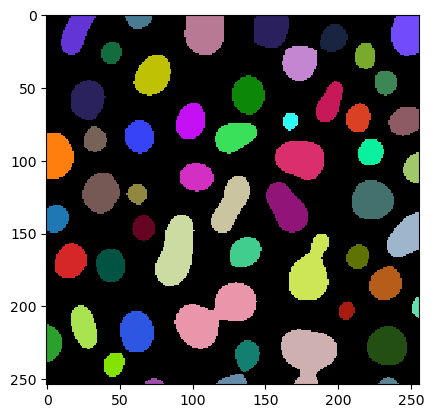

In [5]:
w.set("input", imread("../../data/blobs.tif"))
result = w.get("labeled")

cle.imshow(result, labels=True)

Für die Optimierung eines solchen Workflows benötigen wir ein Ground-Truth-Annotationsbild. Eine spärliche Annotation einiger Objekte ist dafür ausreichend.

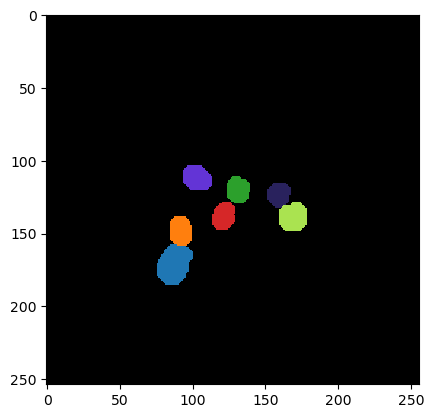

In [6]:
ground_truth = imread("../../data/blobs_sparse_labels.tif")
cle.imshow(ground_truth, labels=True)

Der `JaccardLabelImageOptimizer` verarbeitet einen Workflow und kann Parameter in Bezug auf eine spärliche Ground Truth optimieren. Seine `optimize`-Funktion gibt einen Satz von Parametern zurück, der allen numerischen Parametern des Workflows entspricht.

In [7]:
jlio = JaccardLabelImageOptimizer(w)
best_param = jlio.optimize("labeled", ground_truth, maxiter=20)
best_param

array([4.80023582e+00, 4.44562637e+00, 3.84861161e-04])

Wir können dann den Optimierer verwenden, um diese Parameter für den Workflow festzulegen und anschließend lesen, wo im Workflow die Parameter gesetzt wurden.

In [8]:
jlio.set_numeric_parameters(best_param)

# before printing the workflow, we quickly remove the input image
w.remove('input')
print(w)

Workflow:
blurred <- (<function gaussian_blur at 0x0000023723085A60>, 'input', None, 4.8002358210977345, 4.445626372447739, 0.00038486116050511713)
binarized <- (<function threshold_otsu at 0x00000237232EADC0>, 'blurred')
labeled <- (<function connected_components_labeling_box at 0x000002372316AB80>, 'binarized')



Nachdem wir die Eingabe erneut festgelegt haben, können wir den Workflow auch auf das Bild anwenden und das Ergebnis visuell überprüfen.

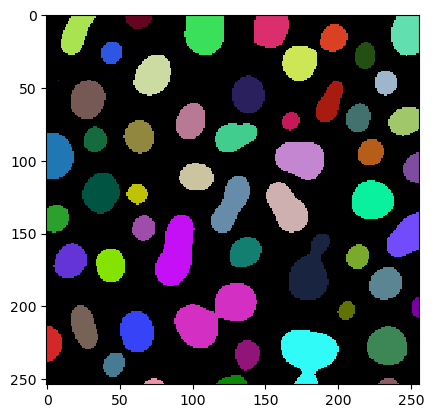

In [9]:
w.set("input", imread("../../data/blobs.tif"))
cle.imshow(w.get("labeled"), labels=True)

## Weitere Einblicke in die Optimierung

Der `JaccardLabelImageOptimizer` ermöglicht es auch, einen Blick auf den zuvor angewendeten Optimierungsprozess zu werfen.

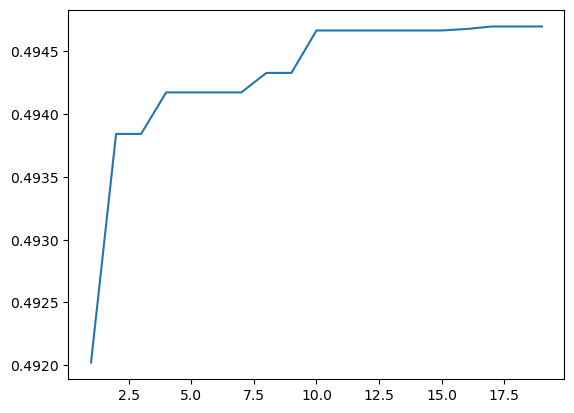

In [10]:
attempt, quality = jlio.get_plot()

plt.plot(attempt, quality)